# Advanced network consolidation

## Refactored version for development purposes

1. consolidate intersections
2. consolidate edges

TODO:

- [x] false planarity
- [ ] figure out clever way of adaptable filters (to identify which polygons should not be there, i.e. which edges should be consolidated)
- [ ] triple/quadruple lines

Future:

- [ ] implementation into OSMnx
- [ ] make it work for both GeoDataFrames and Graph

In [43]:
from itertools import combinations
import collections

import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import momepy as mm
import osmnx as ox
import contextily as ctx

from shapely.ops import polygonize
from scipy.spatial import Voronoi
from sklearn.cluster import KMeans
from sklearn import preprocessing
from clustergram import Clustergram
from libpysal.weights import Queen, W, w_union
from shapely.geometry import LineString

from consolidate import *
from consolidate import _average_geometry, _get_line

## Load data

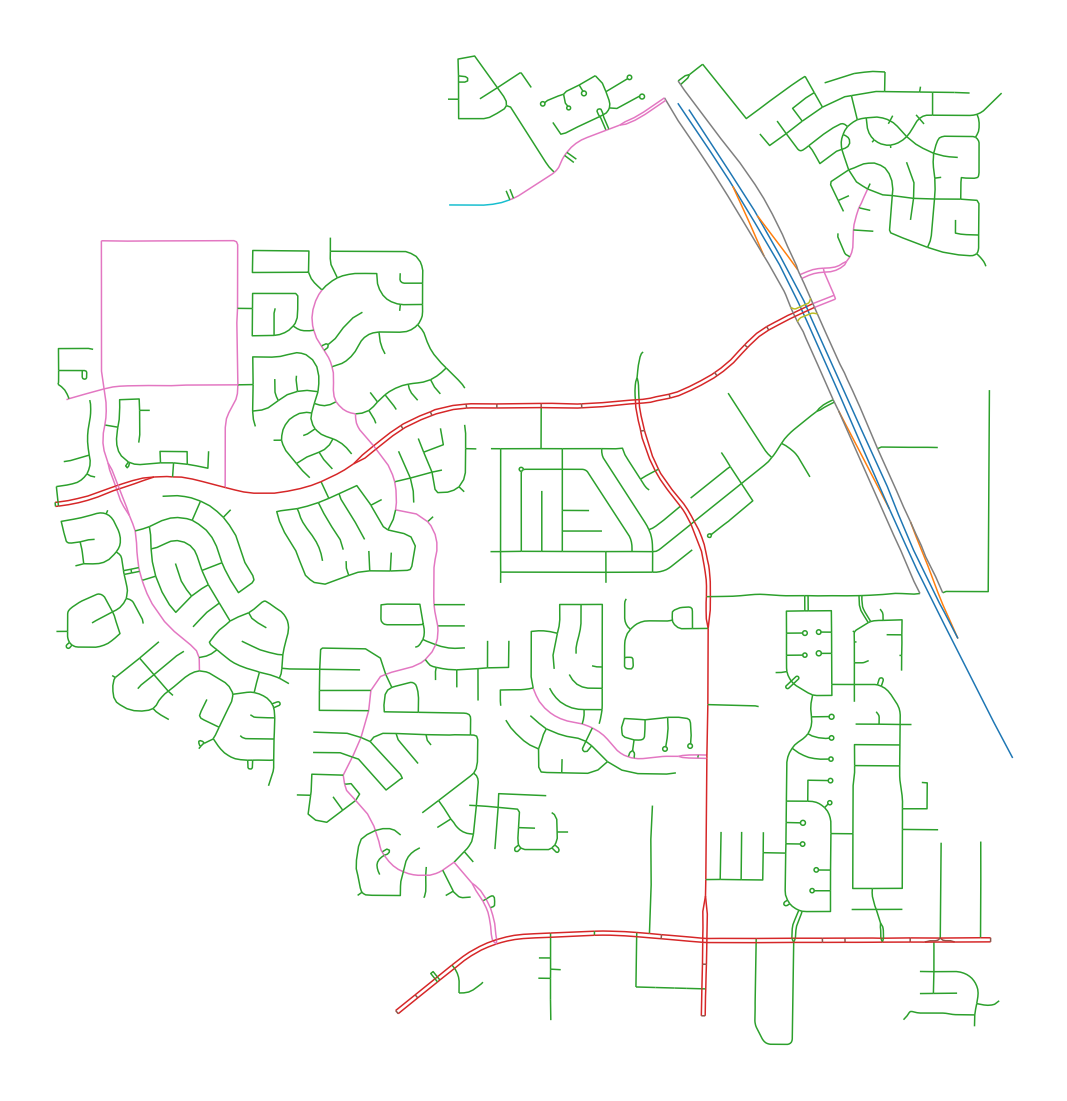

In [45]:
point = (30.027555, -95.615635)
dist = 2000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.plot(gdf.highway.astype(str), figsize=(20, 20)).set_axis_off()

## Fix highways

Requires tags.

In [46]:
fixed_highways = highway_fix(gdf, tick_length=100, allowed_error=5, tolerance=25)

<AxesSubplot:>

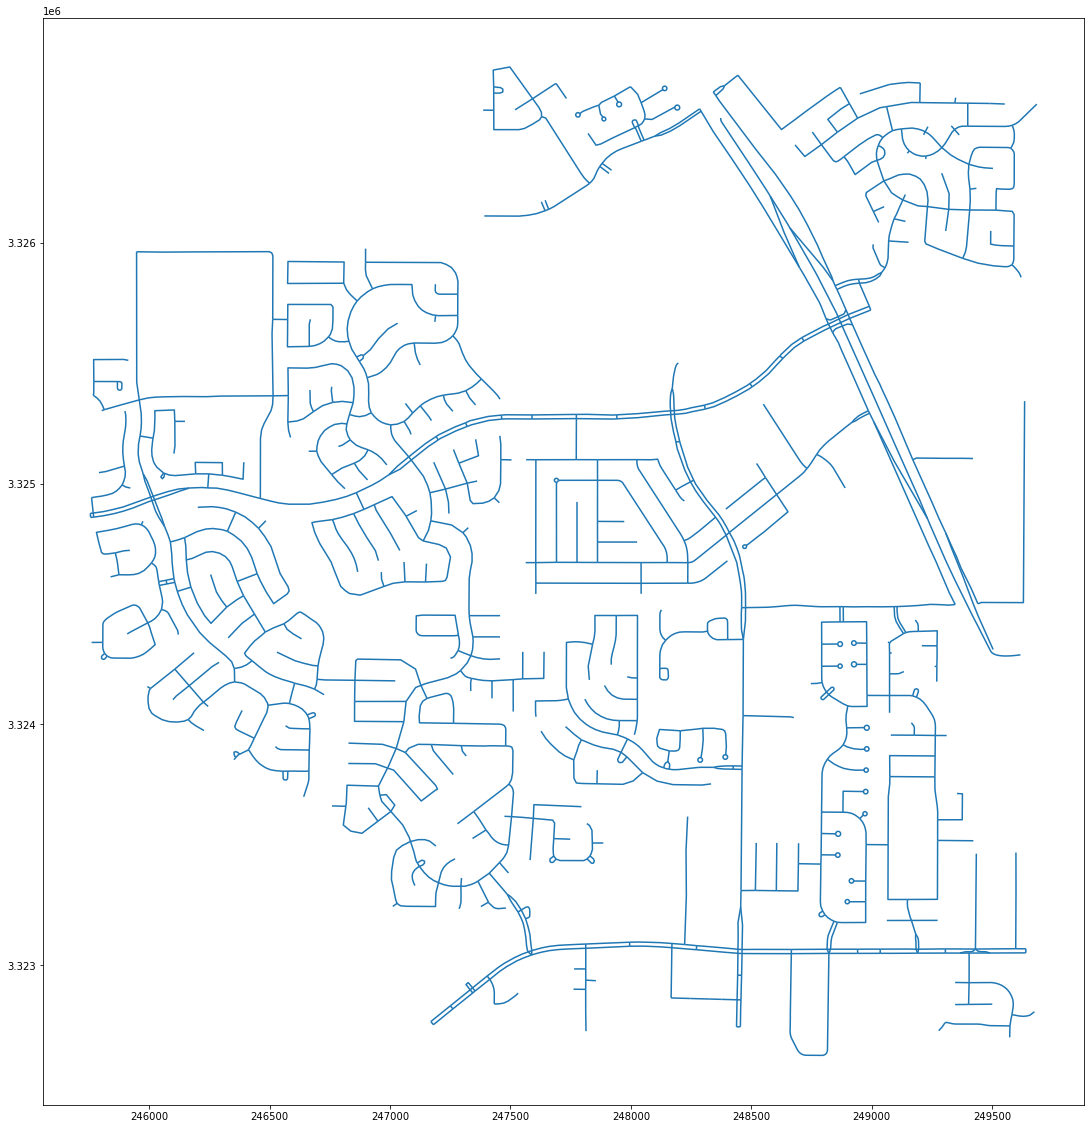

In [47]:
fixed_highways.plot(figsize=(20, 20))

## Consolidate nodes

The process of node consolidation based on DBSCAN is relatively straightforward and stable.

The `consolidate_nodes` function returns consolidated network and newly derived nodes.

In [48]:
%%time
cons_nodes, midpoints = consolidate_nodes(gpd.GeoDataFrame(geometry=fixed_highways), tolerance=30)

CPU times: user 984 ms, sys: 5.64 ms, total: 989 ms
Wall time: 997 ms


<AxesSubplot:>

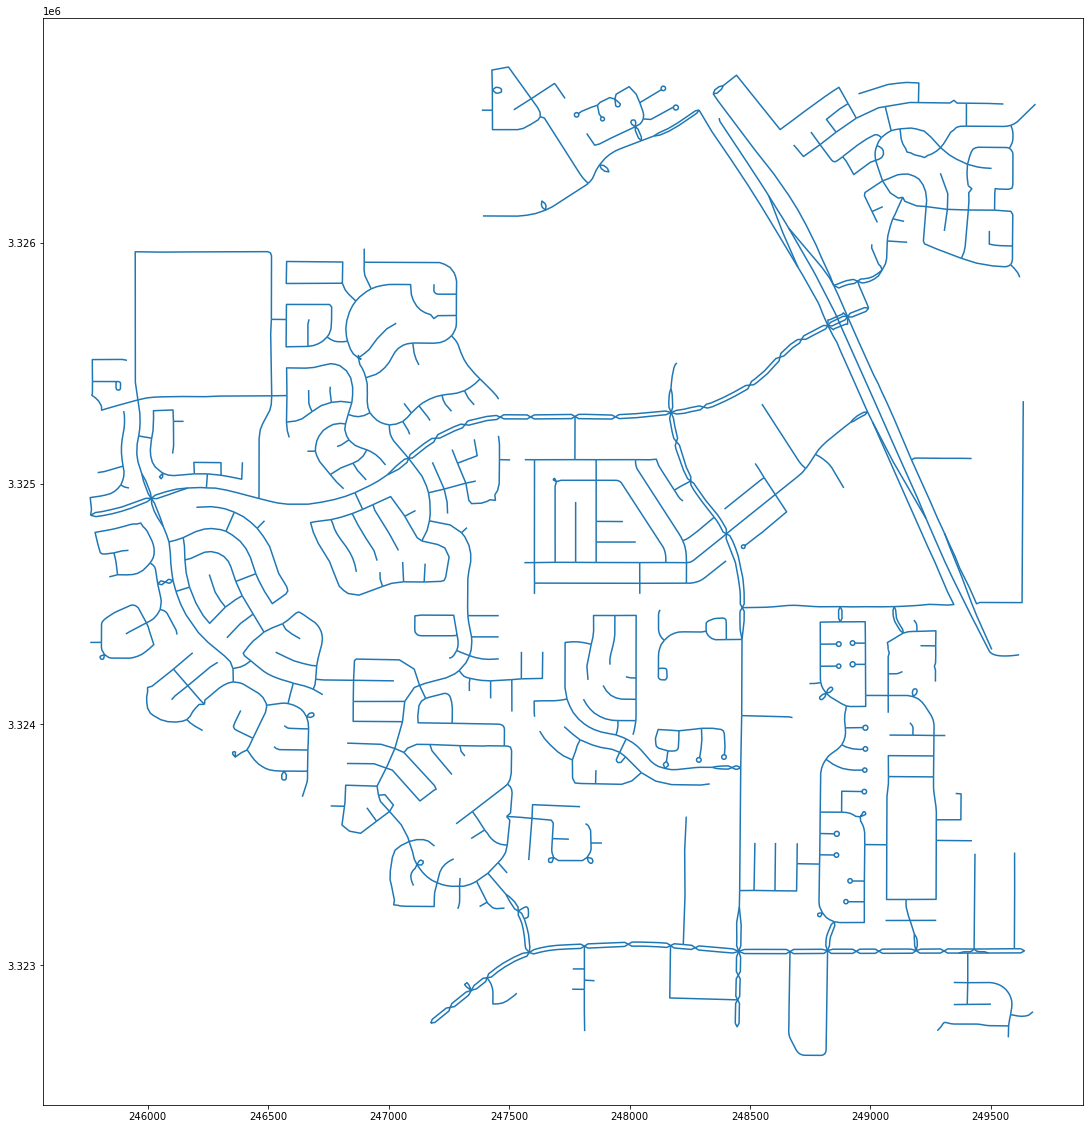

In [49]:
cons_nodes.plot(figsize=(20, 20))

## Consolidate edges

1. Polygonize
2. Select polygons which should be removed
3. Generate average geometry

To preserve planarity (do not create artificial intersections), this schema needs to be a bit more complex.

### Polygonize

In [50]:
network = cons_nodes

In [51]:
# polygonize network
polygonized = polygonize(network.geometry.unary_union)
polygons = gpd.GeoDataFrame(geometry=[g for g in polygonized], crs=network.crs)

### Generate mask

In [82]:
polygons['area'] = polygons.area
polygons['perimeter'] = polygons.length
polygons['circom'] = mm.CircularCompactness(polygons, 'area').series
# polygons['cwa'] = mm.CompactnessWeightedAxis(polygons, 'area',).series
# polygons['convexity'] = mm.Convexity(polygons, 'area').series
# polygons['corners'] = mm.Corners(polygons, verbose=False).series
# polygons['elongation'] = mm.Elongation(polygons).series
# polygons['eri'] = mm.EquivalentRectangularIndex(polygons,).series

(0.0, 50000.0)

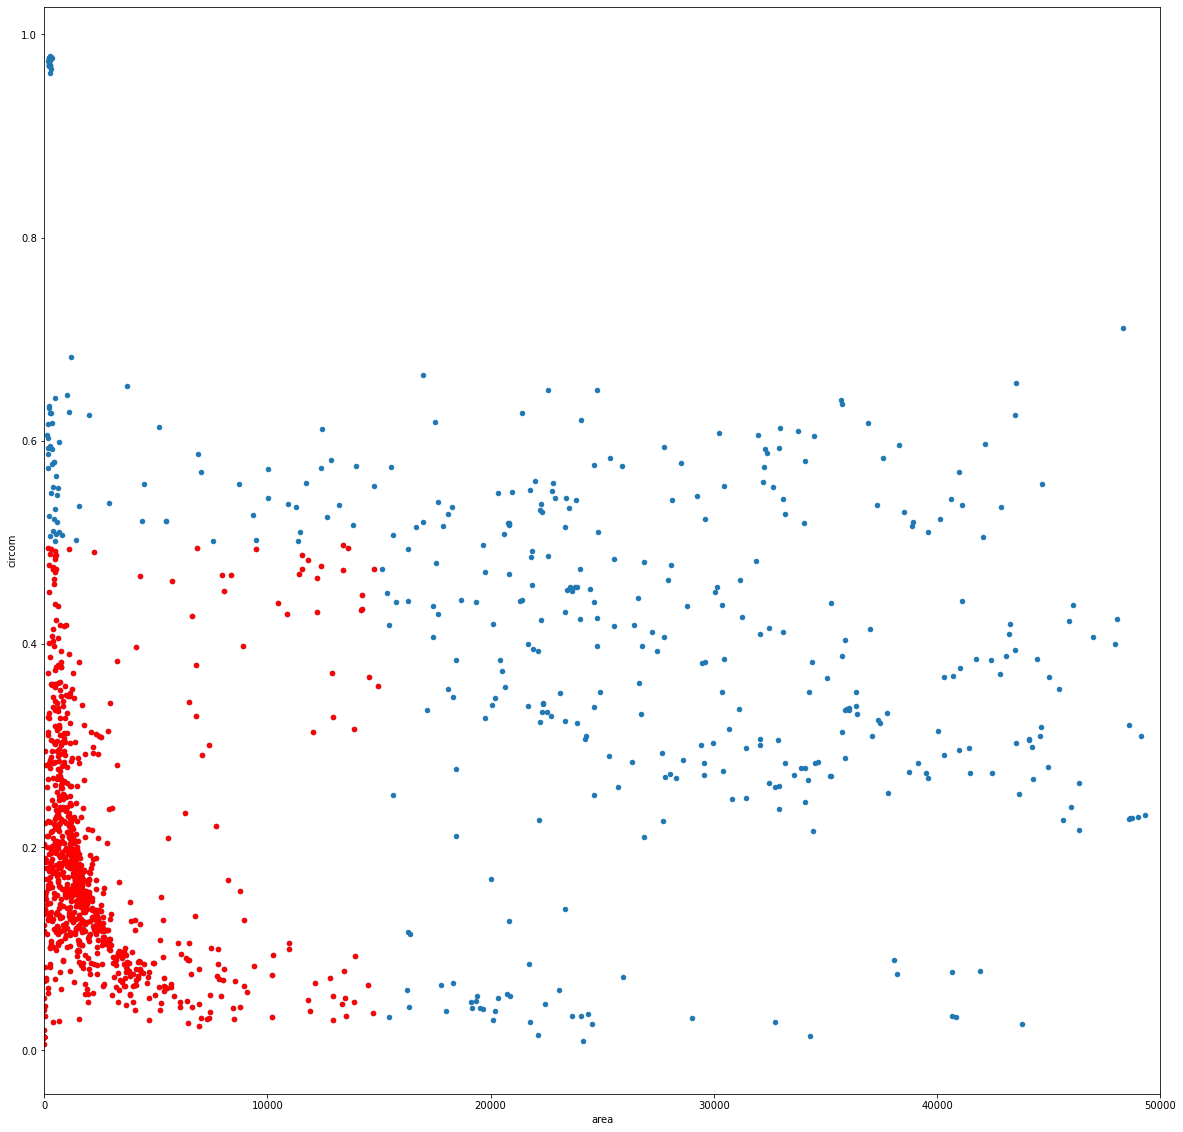

In [223]:
ax = polygons[['circom', 'area']].plot.scatter('area', 'circom', figsize=(20, 20))
polygons[['circom', 'area']][m1].plot.scatter('area', 'circom', ax=ax, color='r')
ax.set_xlim(0, 50000)
# ax.set_ylim(0, 2500)

In [224]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler

In [225]:
data = polygons[['area', 'circom']]

scaler = RobustScaler()
scaled = scaler.fit_transform(data)

(-0.3, 2.0)

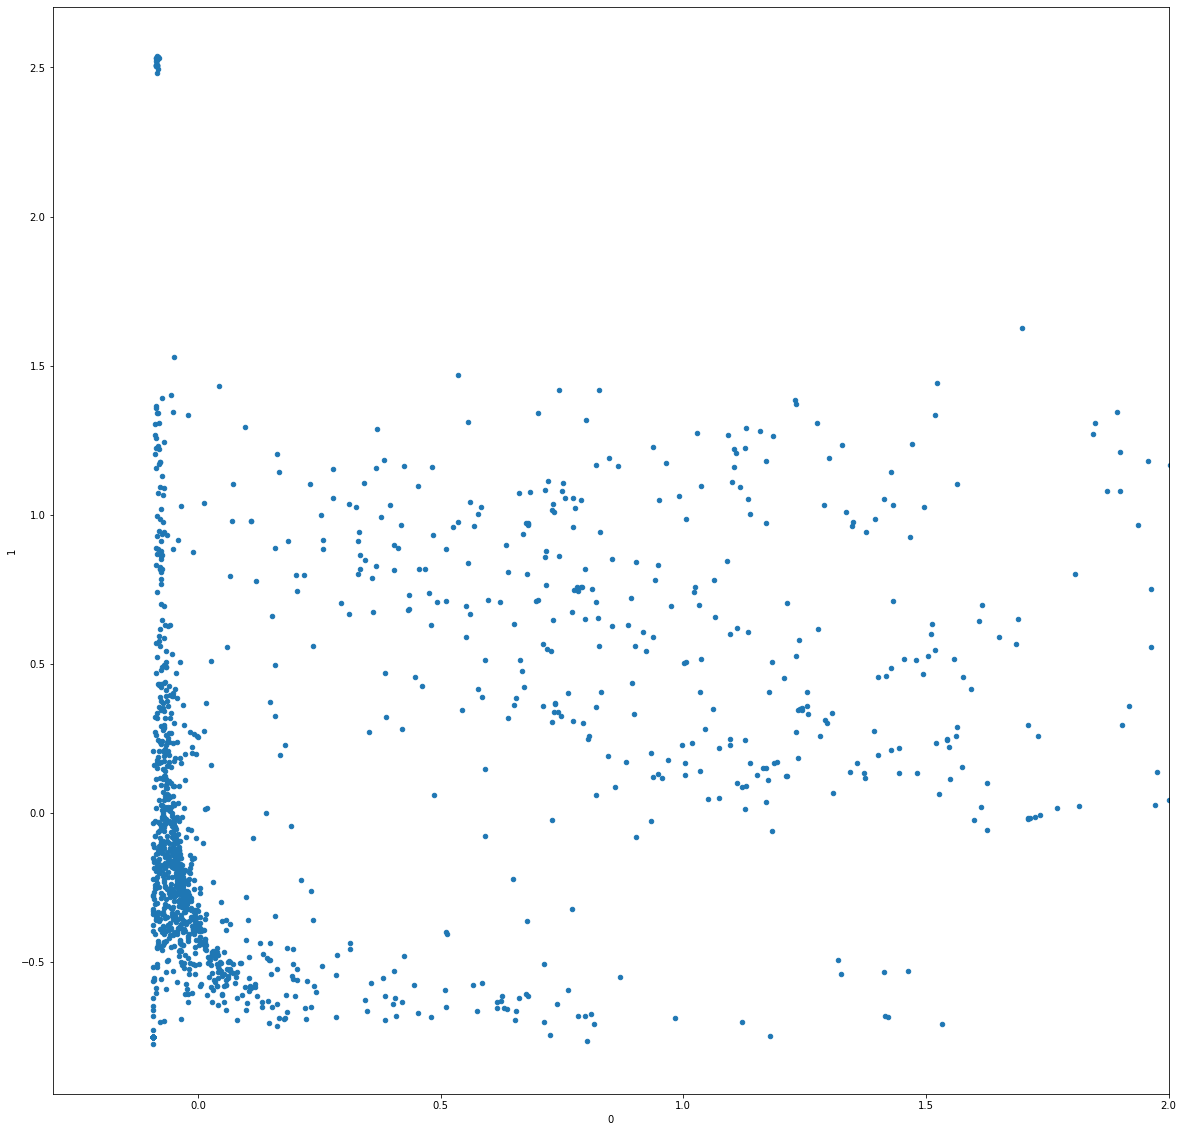

In [227]:
ax = pd.DataFrame(scaled).plot.scatter(0, 1, figsize=(20, 20), cmap='tab20')
# pd.DataFrame(scaled)[m1].plot.scatter(0, 1, ax=ax, color='r')
ax.set_xlim(-.3, 2)

In [235]:
db = DBSCAN(eps=.1, min_samples=10).fit(scaled)

In [236]:
np.unique(db.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 array([426, 995,  32,  30,  52,  26,  23,  11,  11,  32]))

(0.0, 50000.0)

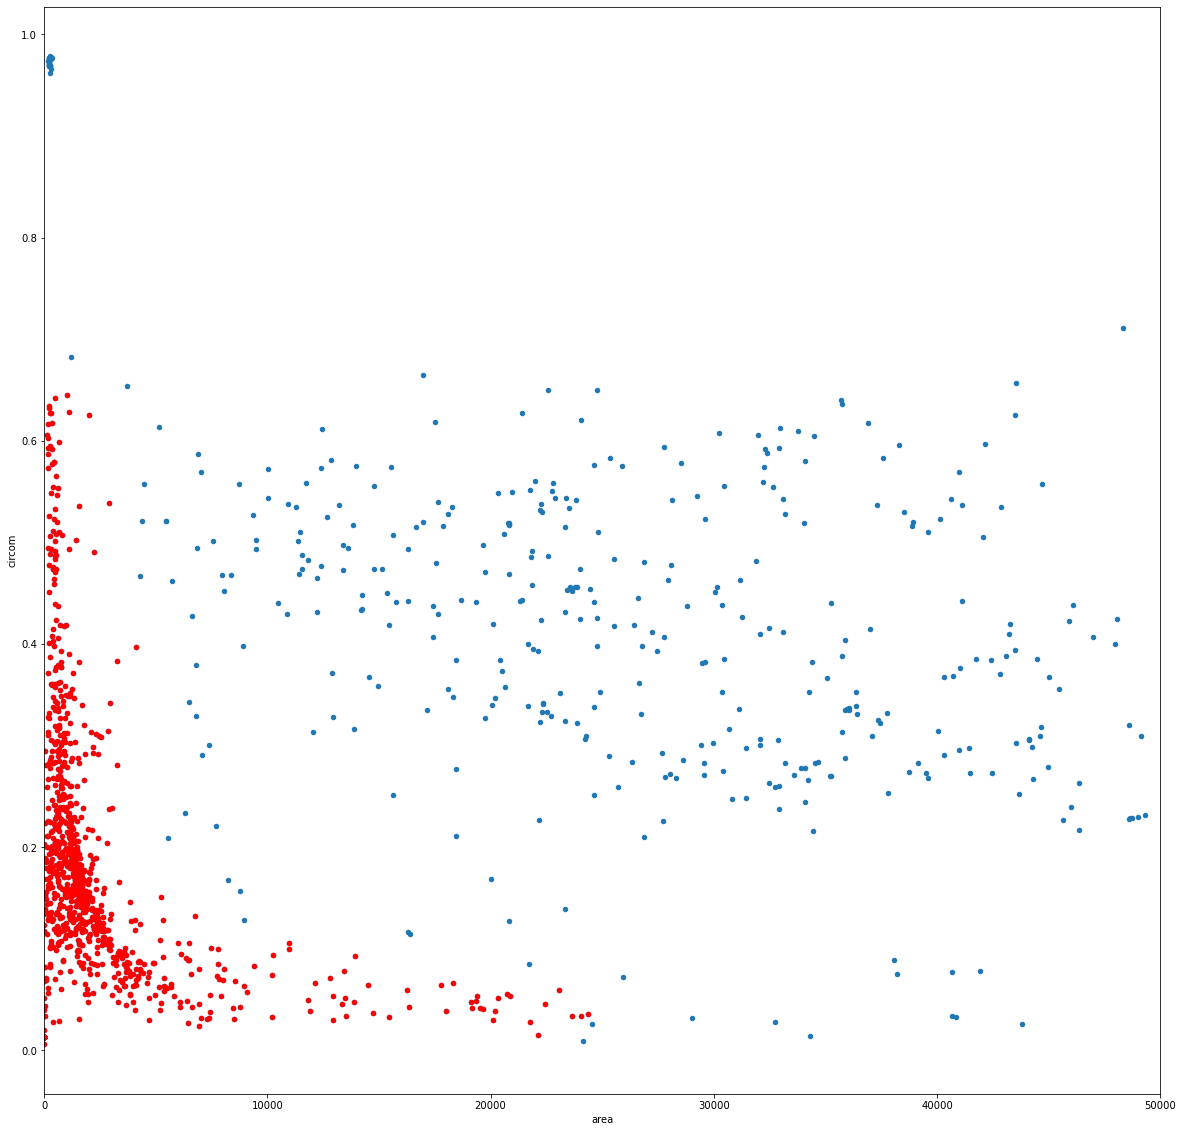

In [237]:
ax = polygons[['circom', 'area']].plot.scatter('area', 'circom', figsize=(20, 20))
polygons[['circom', 'area']][db.labels_ == 0].plot.scatter('area', 'circom', ax=ax, color='r')
ax.set_xlim(0, 50000)
# ax.set_ylim(0, 2500)

<AxesSubplot:>

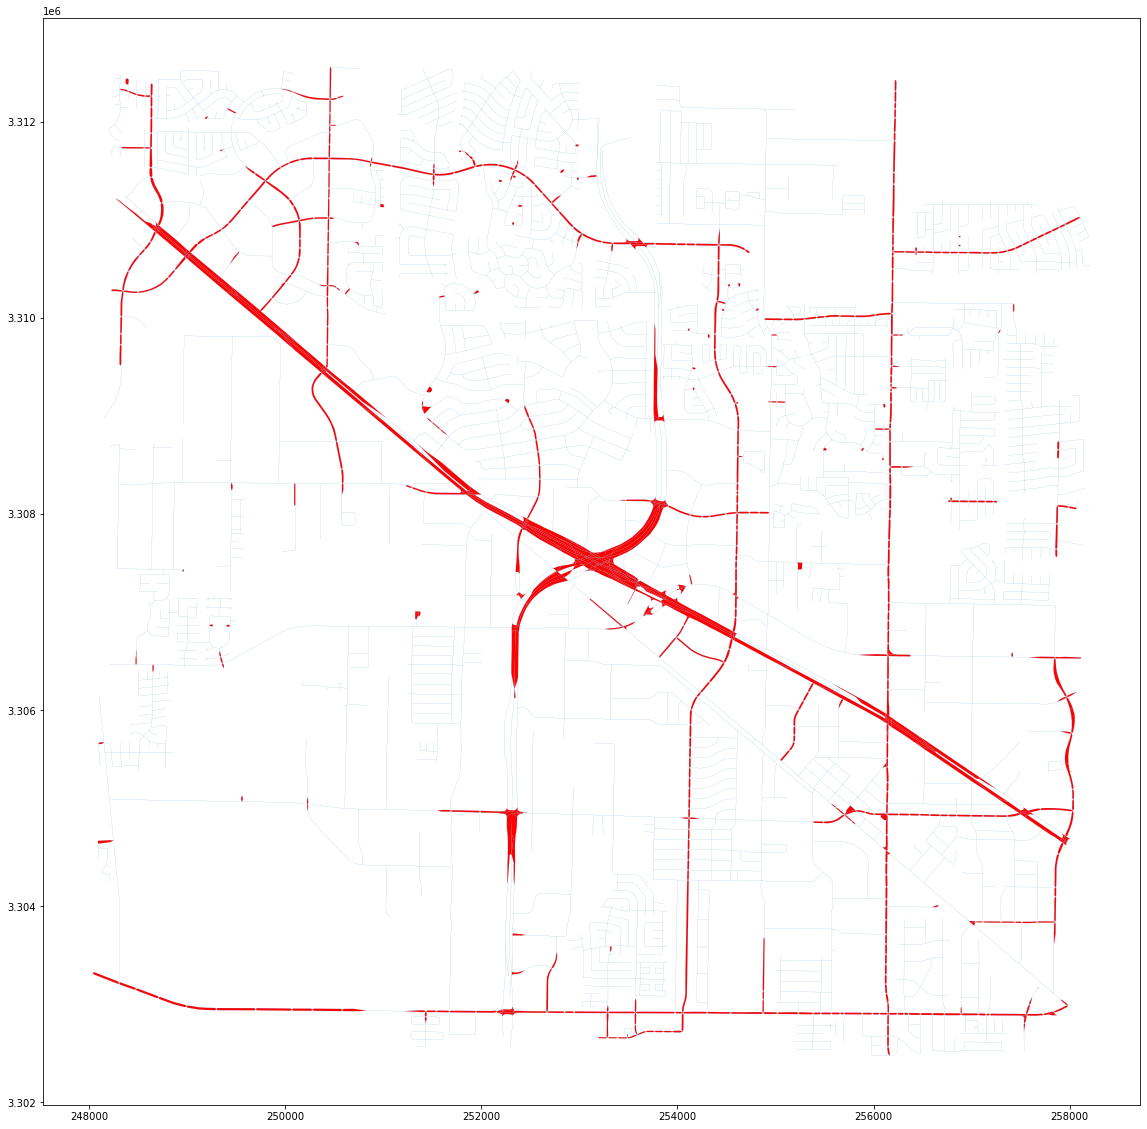

In [238]:
ax = polygons[db.labels_ == 0].plot(figsize=(20, 20),color='r')
cons_nodes.plot(ax=ax, linewidth=.1)

In [56]:
def filter_small(gdf, network, max_size=1000):
    """
    Identify small polygons enclosed by multiple geometries (keeps roundabout at the end of the cul-de-sac)
    """
    small = gdf[gdf.area < max_size]
    inp, res = pygeos.STRtree(small.geometry.values.data).query_bulk(network.geometry.values.data, predicate='covered_by')
    unique, counts = np.unique(res, return_counts=True)
    return gdf.index.isin(small.iloc[unique[counts>1]].index)

In [57]:
m1 = (polygons["area"] < 8000) & (polygons["circom"] < 0.2)
m2 = filter_small(polygons, network, 2000)

In [58]:
mask = m1 | m2

<AxesSubplot:>

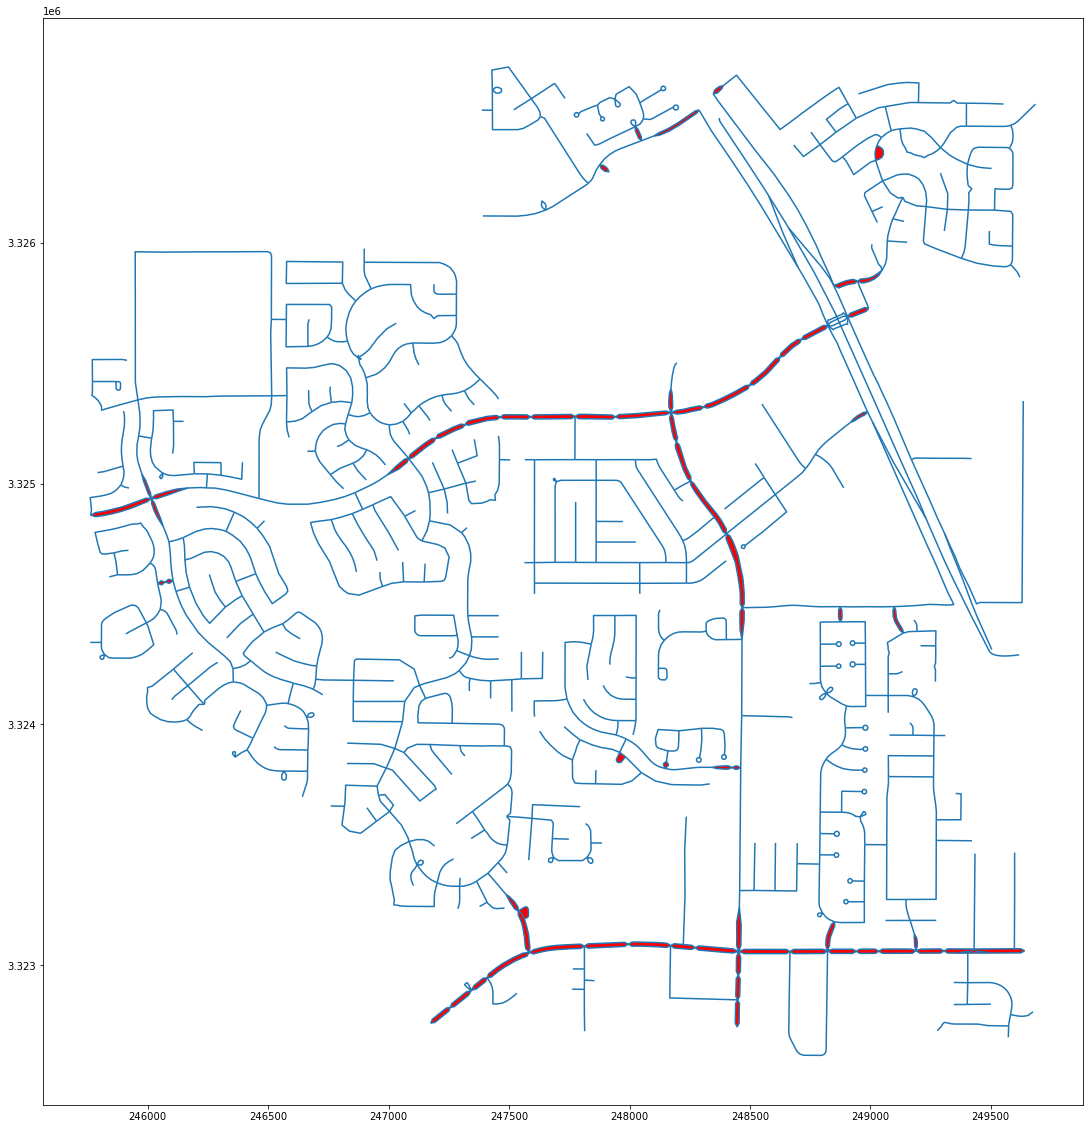

In [41]:
ax = polygons[mask].plot(figsize=(20, 20),color='r')
cons_nodes.plot(ax=ax)

### Simplify network

In [7]:
distance = 2
epsilon = 2

In [15]:

invalid = polygons.loc[mask, 'geometry']

sindex = network.sindex

# iterate over polygons which are marked to be consolidated
# list segments to be removed and the averaged geoms replacing them
averaged = []
to_remove = []
for poly in invalid:
    # temporarily go via pygeos until 0.9 gpd
    real = network.iloc[pygeos.STRtree(network.geometry.values.data).query(pygeos.from_shapely(poly.exterior), predicate='covers')]
    if round(real.length.sum()) == round(poly.length):  # planarity check
        lines = list(real.geometry)
        if lines:
            av = _average_geometry(lines, poly, distance)
            if len(av) > 0:
                to_remove += list(real.index)
                averaged += av

# drop double lines
clean = network.drop(set(to_remove))

# merge new geometries with the existing network
averaged = gpd.GeoSeries(averaged, crs=network.crs).simplify(epsilon).explode()   
result = pd.concat([clean, averaged])

# final result with a clean topology
merge = topology(result)

<AxesSubplot:>

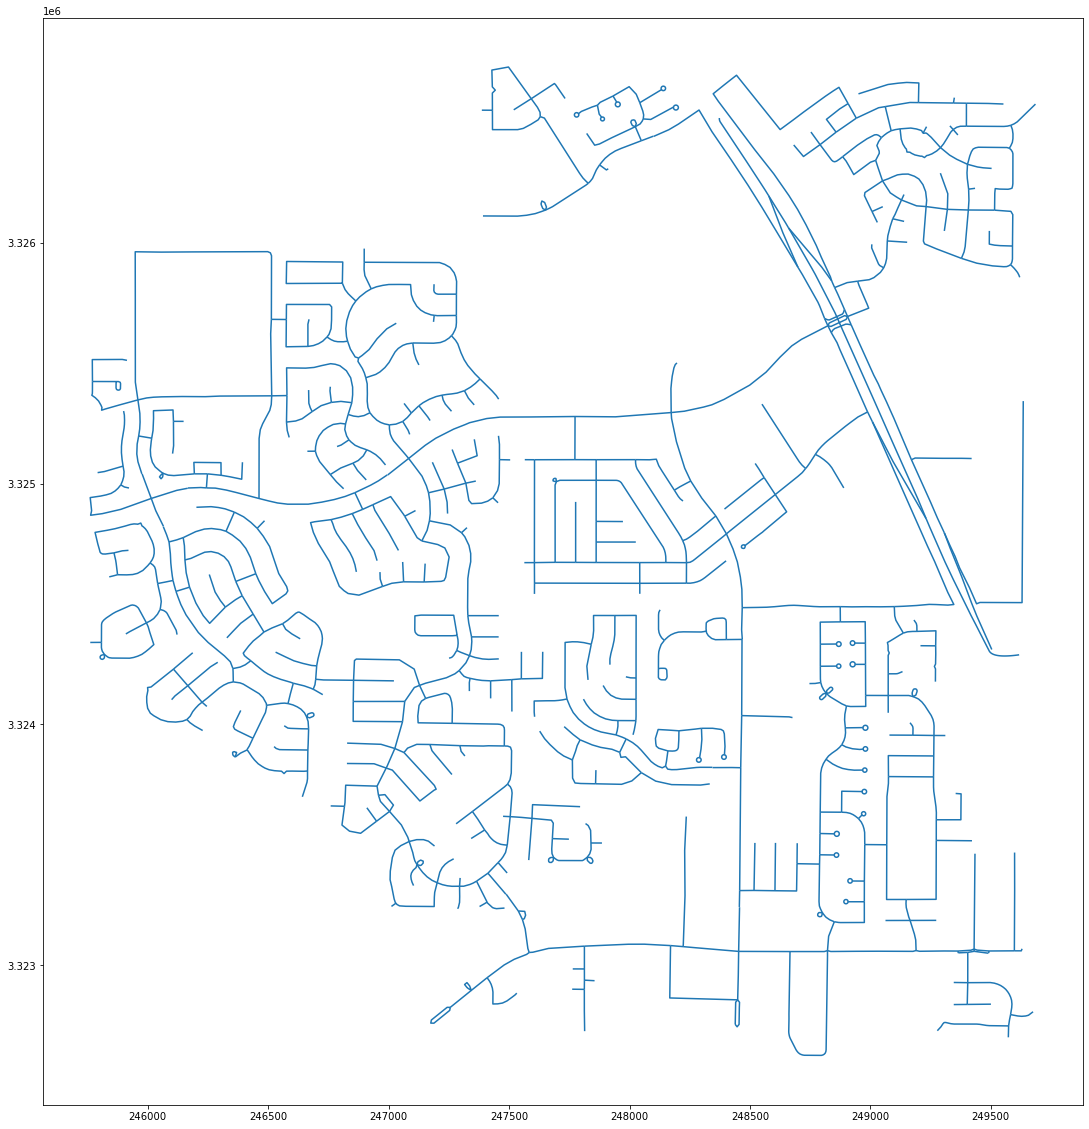

In [16]:
merge.plot(figsize=(20,20))

## Larger area test

<AxesSubplot:>

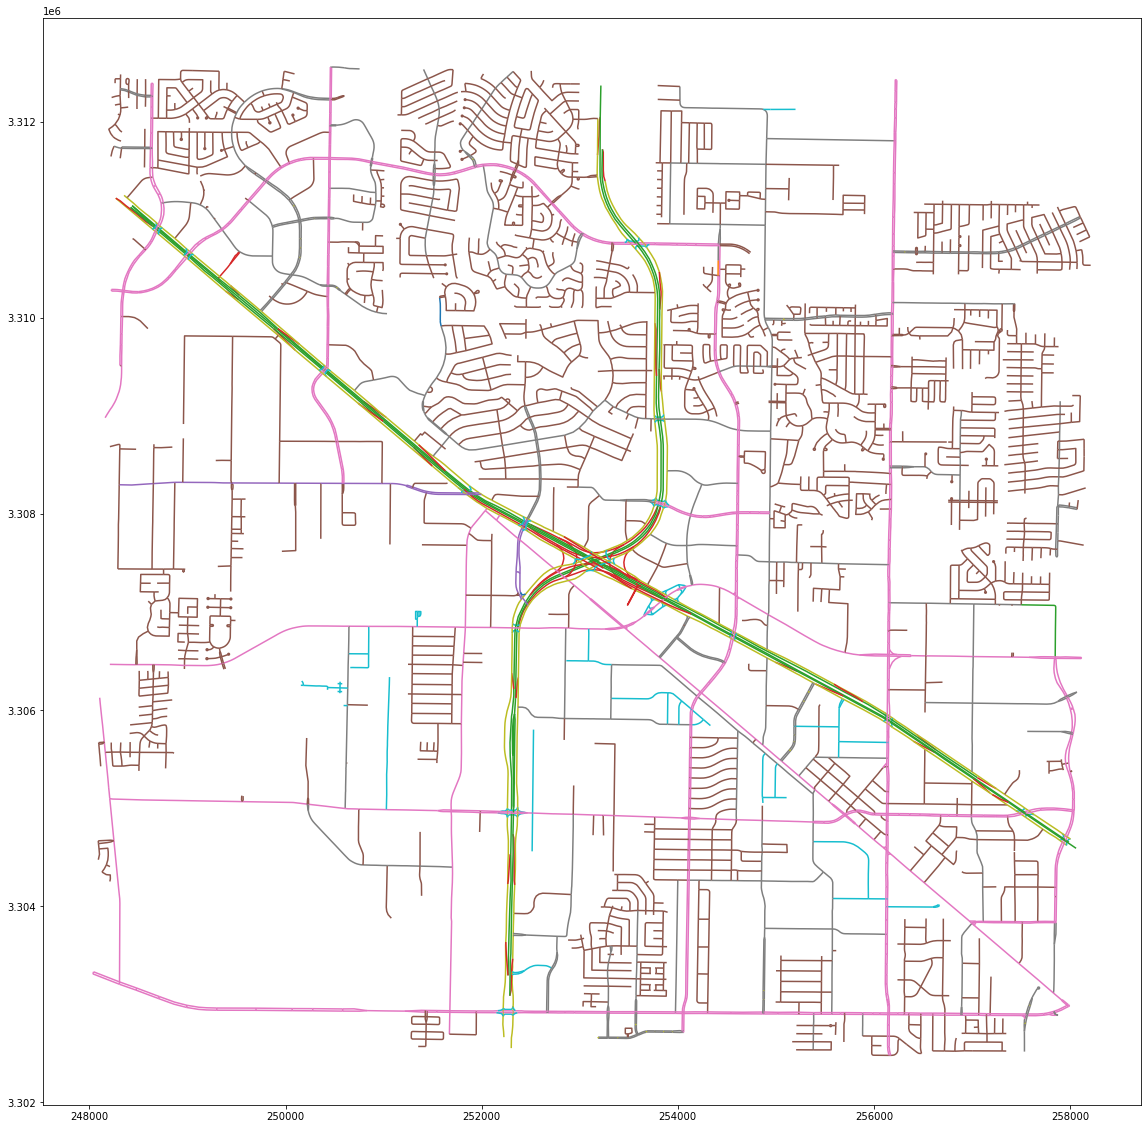

In [74]:
# point = (30.027555, -95.615635)
point = (29.873537, -95.555951)
dist = 5000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.plot(gdf.highway.astype(str), figsize=(20, 20))

In [75]:
fixed_highways = highway_fix(gdf, tick_length=100, allowed_error=1, tolerance=25)

<AxesSubplot:>

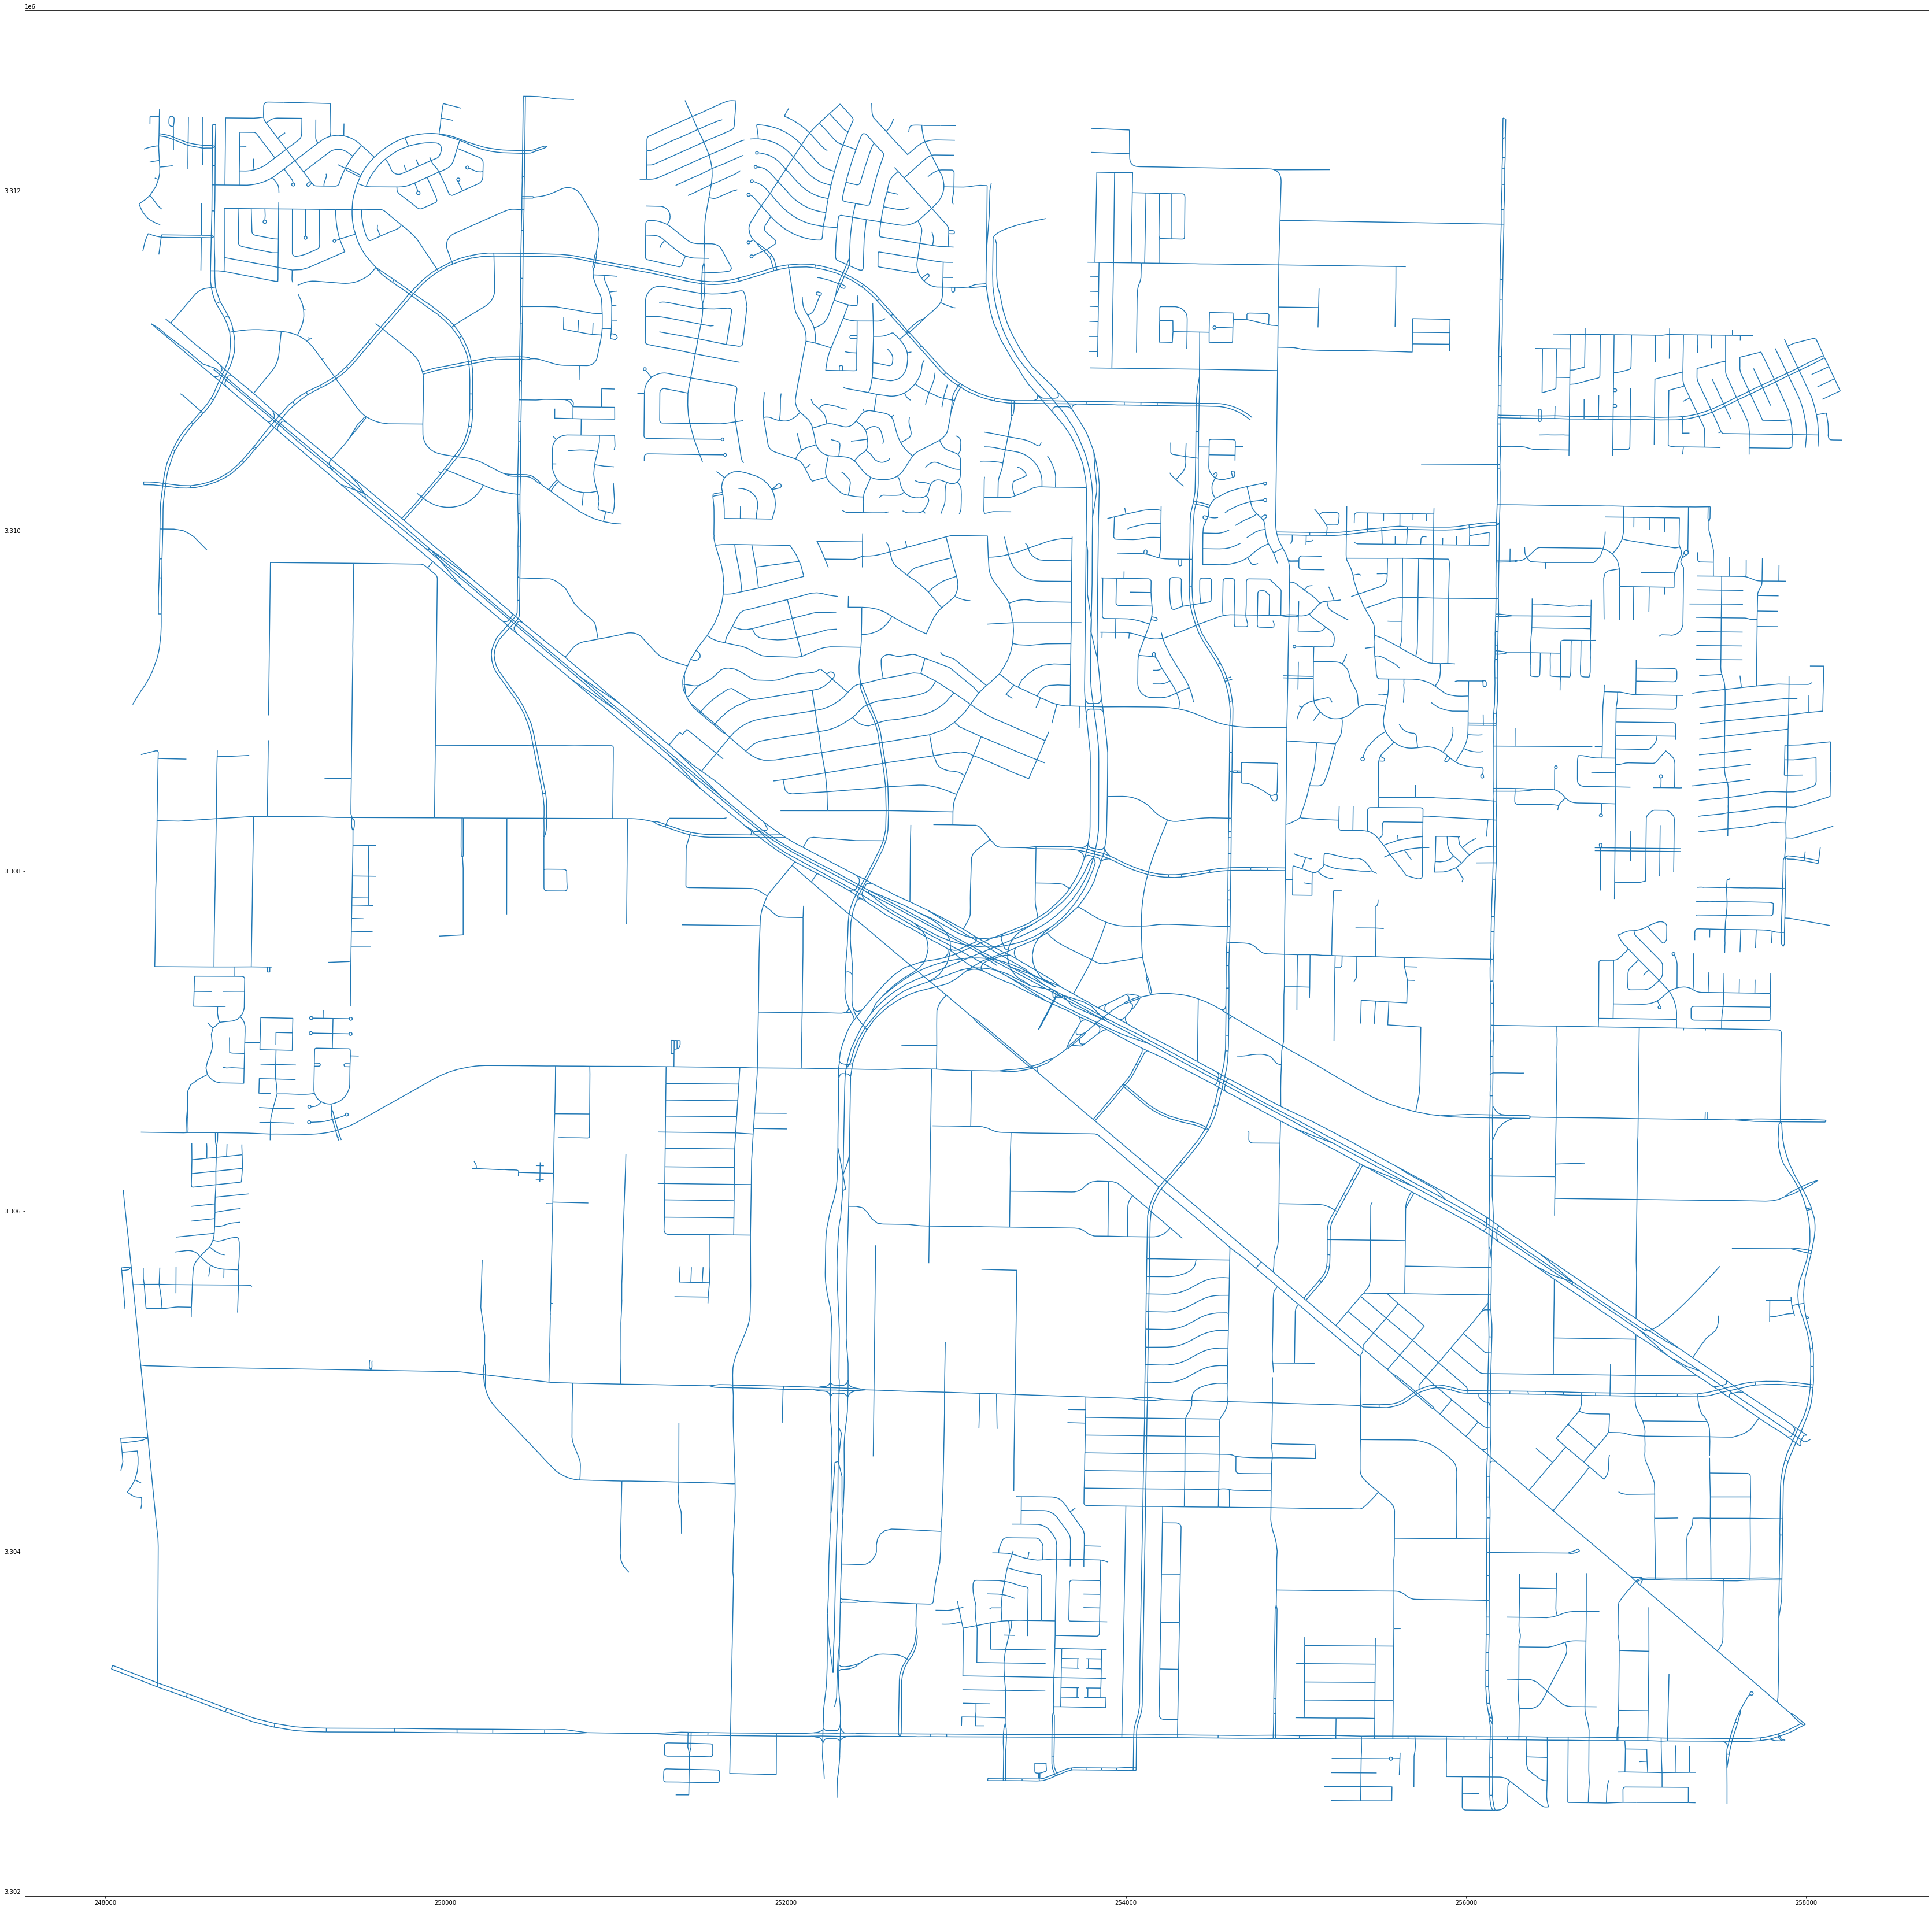

In [26]:
fixed_highways.plot(figsize=(60, 60))

In [76]:
cons_nodes, midpoints = consolidate_nodes(gpd.GeoDataFrame(geometry=fixed_highways), tolerance=25)

In [79]:
network = cons_nodes

# polygonize network
polygonized = polygonize(network.geometry.unary_union)
polygons = gpd.GeoDataFrame(geometry=[g for g in polygonized], crs=network.crs)
polygons['area'] = polygons.area
polygons['circom'] = mm.CircularCompactness(polygons, 'area').series

m1 = (polygons["area"] < 15000) & (polygons["circom"] < 0.5)
m2 = filter_small(polygons, network, 2500)

mask = m1 | m2

<AxesSubplot:>

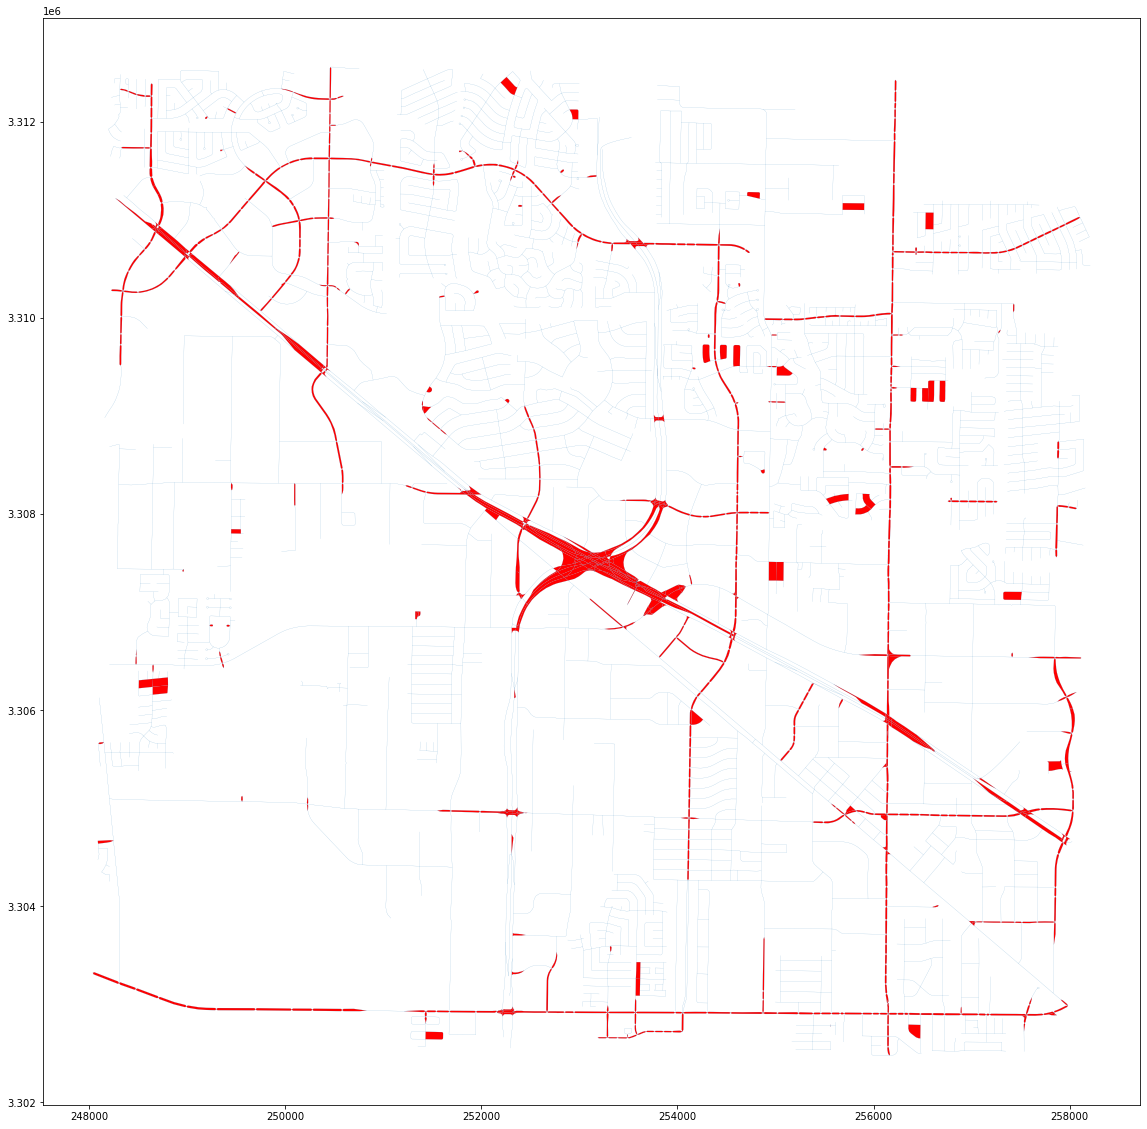

In [80]:
ax = polygons[mask].plot(figsize=(20, 20),color='r', zorder=2)
cons_nodes.plot(ax=ax, linewidth=.1)

In [38]:
invalid = polygons.loc[mask, 'geometry']

sindex = network.sindex

# iterate over polygons which are marked to be consolidated
# list segments to be removed and the averaged geoms replacing them
averaged = []
to_remove = []
for poly in invalid:
#     real = network.iloc[sindex.query(poly.exterior, predicate="intersects")]
#     mask = real.intersection(poly.exterior).type.isin(
#         ["LineString", "MultiLineString"]
#     )
#     real = real[mask]
    
    # temporarily go via pygeos until 0.9 gpd
    real = network.iloc[pygeos.STRtree(network.geometry.values.data).query(pygeos.from_shapely(poly.exterior), predicate='covers')]
    if round(real.length.sum()) == round(poly.length):  # planarity check
        lines = list(real.geometry)
        if lines:
            av = _average_geometry(lines, poly, distance)
            if len(av) > 0:
                to_remove += list(real.index)
                averaged += av

# drop double lines
clean = network.drop(set(to_remove))

# merge new geometries with the existing network
averaged = gpd.GeoSeries(averaged, crs=network.crs).simplify(epsilon).explode()   
result = pd.concat([clean, averaged])

# final result with a clean topology
merge = topology(result)

<AxesSubplot:>

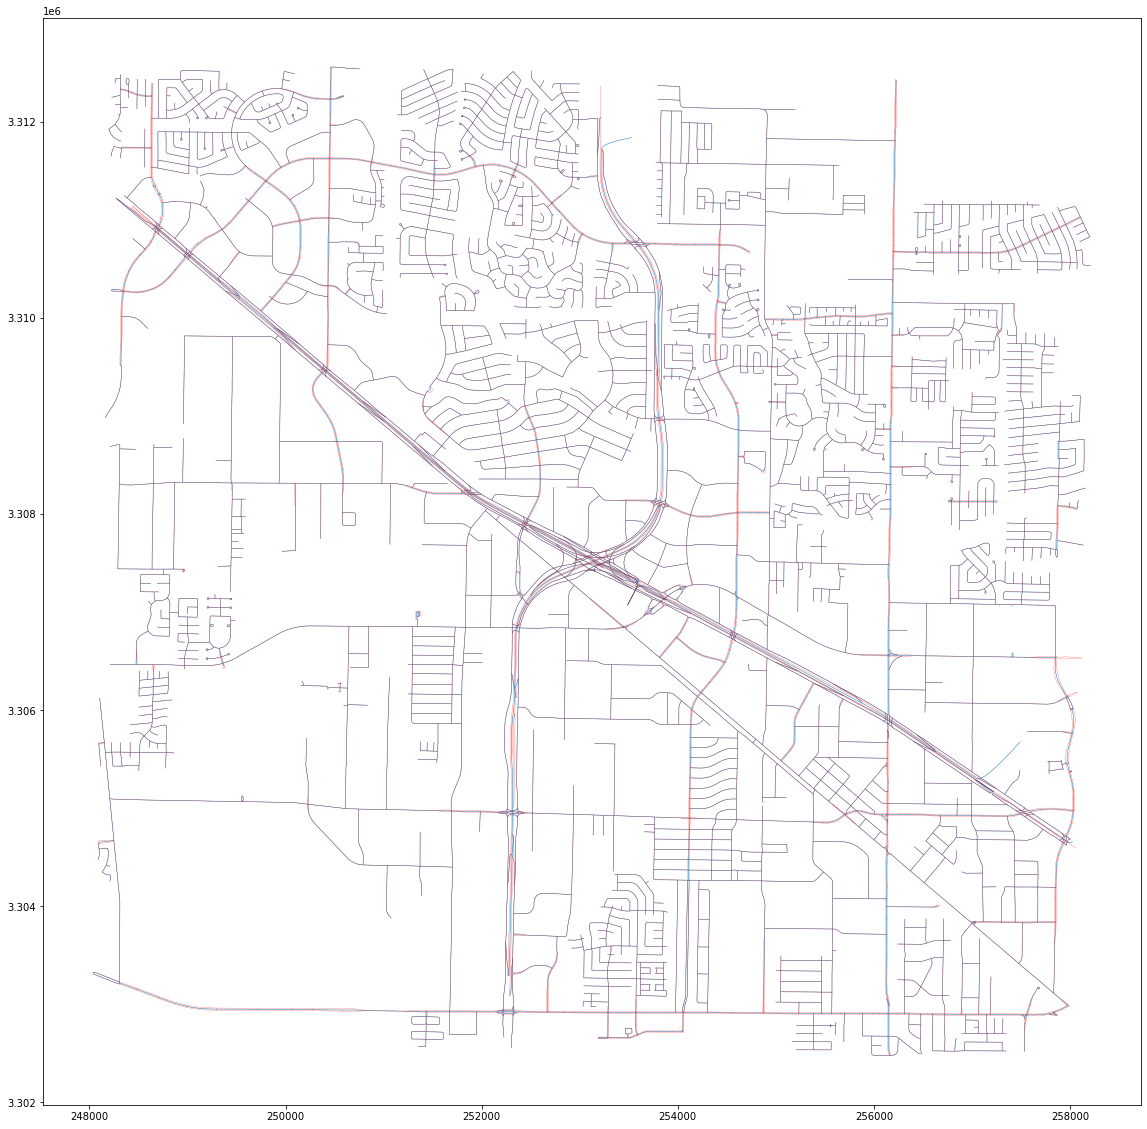

In [39]:
ax = merge.plot(figsize=(20,20), linewidth=.5)
gdf.plot(ax=ax, linewidth=.2, color='r')

<AxesSubplot:>

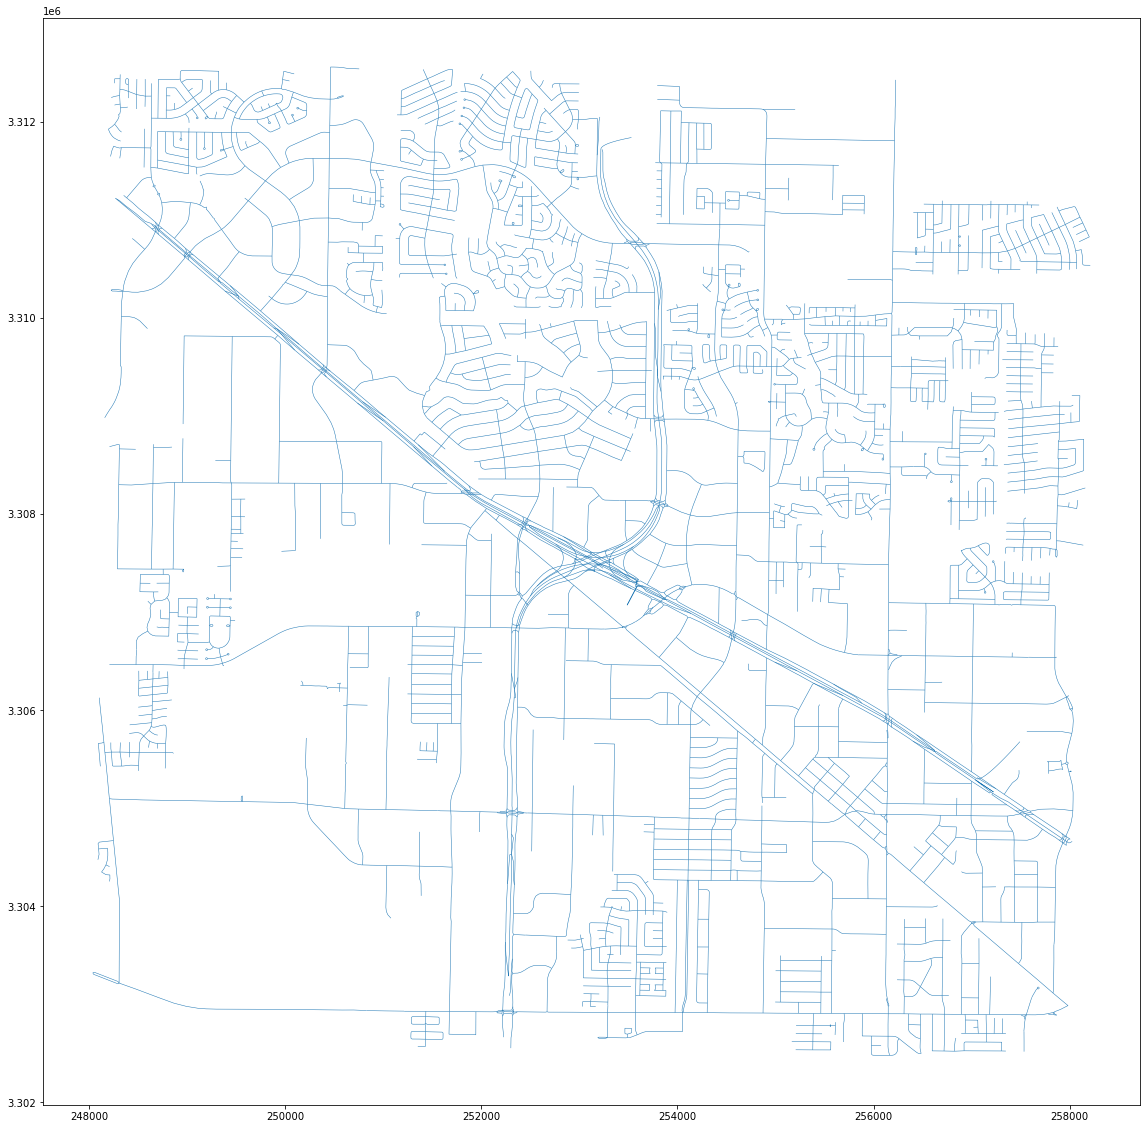

In [40]:
merge.plot(figsize=(20,20), linewidth=.5)

foo                                  geom_wkt_epsg4326  \
0    1  MULTIPOLYGON(((16.550706663337998 48.562715558...   

                                            geometry  
0  MULTIPOLYGON (((16.55071 48.56272, 16.55126 48...

EPSG:4326


<AxesSubplot:>

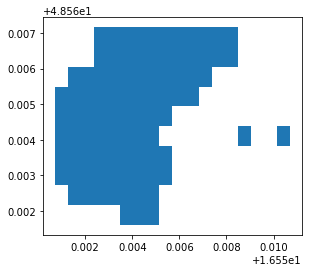

In [42]:
import geopandas as gpd
import pandas as pd

df = gpd.GeoDataFrame({'foo':[1], 'geom_wkt_epsg4326':['MULTIPOLYGON(((16.550706663337998 48.56271555889241, 16.551262218893598 48.56271555889241, 16.551262218893598 48.56216000333681, 16.553484441115998 48.56216000333681, 16.553484441115998 48.56160444778121, 16.555151107782798 48.56160444778121, 16.555151107782798 48.56271555889241, 16.5557066633384 48.56271555889241, 16.5557066633384 48.56382667000361, 16.555151107782798 48.56382667000361, 16.555151107782798 48.5643822255592, 16.5557066633384 48.5643822255592, 16.5557066633384 48.5649377811148, 16.5568177744496 48.5649377811148, 16.5568177744496 48.5654933366704, 16.5573733300052 48.5654933366704, 16.5573733300052 48.566048892226, 16.5584844411164 48.566048892226, 16.5584844411164 48.5671600033372, 16.552373330004798 48.5671600033372, 16.552373330004798 48.566048892226, 16.551262218893598 48.566048892226, 16.551262218893598 48.5654933366704, 16.550706663337998 48.5654933366704, 16.550706663337998 48.56271555889241)),((16.5584844411164 48.56382667000361, 16.559039996672 48.56382667000361, 16.559039996672 48.5643822255592, 16.5584844411164 48.5643822255592, 16.5584844411164 48.56382667000361)),((16.5607066633388 48.5643822255592, 16.5601511077832 48.5643822255592, 16.5601511077832 48.56382667000361, 16.5607066633388 48.56382667000361, 16.5607066633388 48.5643822255592)))']})

from shapely import wkt
df['geometry'] = df['geom_wkt_epsg4326'].apply(wkt.loads)
display(df.head())
df.crs = "EPSG:4326"
print(df.crs)

df.plot()

<AxesSubplot:>

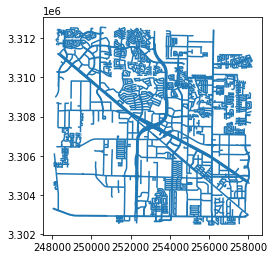

In [243]:
index = np.array(range(10))

if index:
    print('yay')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [244]:
s1 = pd.Series([0, 2, 3], index=['a', 'b', 'c'])
s2 = pd.Series([0, 2, 3])

In [247]:
s1.reindex(s2)

0   NaN
2   NaN
3   NaN
dtype: float64

In [250]:
pd.Series(s1, index=[0, 1, 2])

0   NaN
1   NaN
2   NaN
dtype: float64

In [253]:
gdf.geometry.values

<GeometryArray>
 ...
Length: 4816, dtype: geometry